# MCM complexes are barriers that restrict cohesin-mediated loop extrusion

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 3
+ S9

#### Archives:
+ Cohesin-MCM_wt_highsalt.yama
+ Cohesin-MCM_wt_lowsalt.yama
+ Cohesin-only_lowsalt.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji_MARS-beta18.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from tqdm.notebook import tqdm
from functools import reduce
from scipy.stats import norm

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Cohesin-MCM_wt_highsalt.yama',
                     'Cohesin-MCM_wt_lowsalt.yama',
                     'Cohesin-only_lowsalt.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [28]:
set_style_paper()

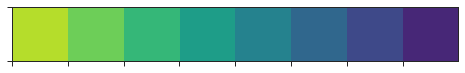

In [6]:
sns.palplot(palette)

In [91]:
# change to desired output directory
dir_out = '/Users/matze/Documents/PhD/Manuscripts/MCM-cohesin_sliding/Figures/SVGs/'
dir_out

'/Users/matze/Documents/PhD/Manuscripts/MCM-cohesin_sliding/Figures/SVGs/'

### Instantiate selected archives

In [8]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

MCM variant not found. Setting default to n/a



### Add df_noidle to all molecules

In [9]:
for archive in tqdm(DnaMoleculeArchive.instances):
    
    archive.add_df_noidle(prefix='Cohesin_1_', specifier='idle')
    

### Archives Overview

In [10]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,NaCl concentration,MCM variant,archive validation
Cohesin-MCM_wt_highsalt,12,106,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,500 mM,wt,passed
Cohesin-MCM_wt_lowsalt,20,181,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,150 mM,wt,passed
Cohesin-only_lowsalt,4,59,Halo-JF549-Cohesin,ATP,150 mM,n/a,passed


### Functions

In [11]:
def calc_msd(df, prefix, msd_col, time_col, tau=1, start=np.nan, end=np.nan):
    """
    Calculates mean square displacement of molecules.
    Remove pairs with missing frames in interval, do not drop NaN values!
    *df: dataframe
    *prefix: protein prefix
    *msd_col: column in df to calculate msd (without protein prefix!)
    *time_col: time column in df (without protein prefix!)
    *tau: time delta used to calculate msd (without protein prefix!)
    *ignore_region: provide region name (regex) which is ignored for msd calculation (default False)
    
    returns (msd, dtime)
    msd: mean squared error
    dtime: mean time difference underlying msd calculation
    """
    
    # if not start / end was specified by used, set to max range
    if np.isnan(start):
        #start=df[prefix+time_col].iloc[0]
        start=df[prefix+time_col].min()
        
    if np.isnan(end):
        #end=df[prefix+time_col].iloc[-1]
        end=df[prefix+time_col].max()
        
    # will be a more accurate way to calculate MSD due to existing NaN values
    diffs = []
    dtimes = []
    for row in df.index:
        try:
            # check if sliding window range
            if (df.loc[row, prefix+time_col] >= start and df.loc[row+tau, prefix+time_col] <= end):

                # check if we have consecutive frames (T) which are not null
                if (((df.loc[row+tau, prefix+'T'] - df.loc[row, prefix+'T']) == tau) and not
                    ((np.isnan(df.loc[row+tau, prefix+msd_col]) or np.isnan(df.loc[row, prefix+msd_col])))):

                    diffs.append(df.loc[row+tau, prefix+msd_col] - df.loc[row, prefix+msd_col])
                    dtimes.append(df.loc[row+tau, prefix+time_col] - df.loc[row, prefix+time_col])

                else:
                    #skip to next row
                    continue

        # end of df
        except KeyError:
            break
            
    return np.mean(np.square(diffs)), np.mean(dtimes)

In [12]:
def calc_ars1_encounters(molecule):
    """
    Calculates encounters and encounter outcomes with ARS1 for a molecule object.
    """
    
    #reset to 0 in case it reruns
    #visualized encounters
    molecule.ars1_encounters_vis = 0
    
    #passage events
    molecule.ars1_pass = 0
    
    #blocking events
    molecule.ars1_block = 0
    
    #time between consecutive passage events
    molecule.pass_times = []
    
    #observation time
    molecule.timespan = molecule.df.filter(regex='Cohesin_1_').dropna()['Cohesin_1_Time_(s)'].max()
    
    
    #get number of theoretical encounters with ARS1 from cohesin only molecules
    try:
        if molecule.proteins['MCM'] > 0:
            pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].mean()
        else:
            pos_ars1 = 5557.5
    except KeyError:
        pos_ars1 = 5557.5

    for row in molecule.df.index:
        
        try:
            #direct collision
            if abs(molecule.df.loc[row,'Cohesin_1_Position_on_DNA'] - pos_ars1) < 1500:
                
                molecule.ars1_encounters_vis+=1

                #passed
                if (molecule.df.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']-500 or 
                    molecule.df.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
                    
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df.loc[row+1,'Cohesin_1_Time (s)'])

                #blocked
                else:
                    molecule.ars1_block+=1

            #no direct collision
            else:

                if (molecule.df.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']-500) or (
                    molecule.df.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
            
                    molecule.ars1_encounters_vis+=1
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df.loc[row+1,'Cohesin_1_Time (s)'])

        except KeyError:
            #print('last row reached, skip.')
            pass
    
    #calculate difference between passage times
    molecule.pass_diff = np.diff(molecule.pass_times,n=1)

In [13]:
def calc_ars1_encounters_noidle(molecule):
    """
    Calculates encounters and encounter outcomes with ARS1 for a molecule object.
    """
    
    #reset to 0 in case it reruns
    #visualized encounters
    molecule.ars1_encounters_vis_ni = 0
    
    #passage events
    molecule.ars1_pass_ni = 0
    
    #blocking events
    molecule.ars1_block_ni = 0
    
    #time between consecutive passage events
    molecule.pass_times_ni = []
       
    
    #get number of theoretical encounters with ARS1 from cohesin only molecules
    try:
        if molecule.proteins['MCM'] > 0:
            pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].mean()
        else:
            pos_ars1 = 5557.5
    except KeyError:
        pos_ars1 = 5557.5

    for row in molecule.df_noidle.index:
        
        try:
            #direct collision
            if abs(molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA'] - pos_ars1) < 1500:
                
                molecule.ars1_encounters_vis_ni+=1

                #passed
                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-500 or 
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
                    
                    molecule.ars1_pass_ni+=1
                    molecule.pass_times_ni.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

                #blocked
                else:
                    molecule.ars1_block_ni+=1

            #no direct collision
            else:

                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-500) or (
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
            
                    molecule.ars1_encounters_vis_ni+=1
                    molecule.ars1_pass_ni+=1
                    molecule.pass_times_ni.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

        except KeyError:
            #print('last row reached, skip.')
            pass
    
    #calculate difference between passage times
    molecule.pass_diff_ni = np.diff(molecule.pass_times_ni,n=1)

### Generate main df

In [14]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['lifetime', 'initial_intensity', 'msd', 'dtime', 'd_coeff']

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)

In [15]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()

Empty DataFrame
Columns: [(Cohesin_1_, d_coeff), (Cohesin_1_, dtime), (Cohesin_1_, initial_intensity), (Cohesin_1_, lifetime), (Cohesin_1_, msd), (MCM_1_, d_coeff), (MCM_1_, dtime), (MCM_1_, initial_intensity), (MCM_1_, lifetime), (MCM_1_, msd)]
Index: []

In [16]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'nacl'] = archive.nacl
        
        # assign MCM variant and change to n/a for molecules without MCM on DNA
        try:
            if molecule.proteins['MCM'] > 0:
                df.loc[molecule.uid,'MCM_variant'] = archive.mcm
            else:
                df.loc[molecule.uid,'MCM_variant'] = 'n/a'
        except KeyError:
            # archive has 'n/a' by default
            df.loc[molecule.uid,'MCM_variant'] = archive.mcm
        
        try:
            df.loc[molecule.uid,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
        except KeyError:
            pass
        
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)
        
        # calculate encounters between Cohesin and ARS1 here
        calc_ars1_encounters(molecule)
        df.loc[molecule.uid,'Visualized encounters'] = molecule.ars1_encounters_vis
        df.loc[molecule.uid,'ARS1 pass'] = molecule.ars1_pass
        df.loc[molecule.uid,'ARS1 block'] = molecule.ars1_block
        
        # same as above but exclude idle times
        calc_ars1_encounters_noidle(molecule)
        df.loc[molecule.uid,'Visualized encounters ni'] = molecule.ars1_encounters_vis_ni
        df.loc[molecule.uid,'ARS1 pass ni'] = molecule.ars1_pass_ni
        df.loc[molecule.uid,'ARS1 block ni'] = molecule.ars1_block_ni

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #observation time (in s) defined by tracking length
            df.loc[molecule.uid,(prefix,'timespan_(s)')] = molecule.df.filter(regex=prefix).dropna()[prefix+'Time_(s)'].max()
            
            # average position on DNA (try mean but might switch to median due to noise)
            df.loc[molecule.uid,(prefix,'avg_position_on_dna')] = molecule.df[prefix+'Position_on_DNA'].mean()
            
            # MSD (kbp^2) & dtime (s)    
            msd, dtime = calc_msd(df=molecule.df_noidle, prefix=prefix, msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)
            df.loc[molecule.uid,(prefix,'msd')] = msd/(1000**2)
            df.loc[molecule.uid,(prefix,'dtime')] = dtime

            # diffusion coefficient (kbp^2/s)
            df.loc[molecule.uid,(prefix,'d_coeff')] = df.loc[molecule.uid,(prefix,'msd')] / (2*df.loc[molecule.uid,(prefix,'dtime')])
            
            # pauses:
            # number of pauses
            #- do not consider pauses with less than 25 frames (region.end - region.start)
            
            df.loc[molecule.uid,(prefix,'number_pauses')] = len(list(filter(
                lambda region: ('idle' in region.name) and (region.prefix == prefix) and 
                (region.end - region.start >= 25), molecule.regions)))
            
            # cumulative pause duration
            cum_duration = 0
            
            for region in molecule.regions:
                
                # check again for the right regions, prefixes and duration
                if ('idle' in region.name) and (region.prefix == prefix) and (region.end - region.start >= 25):
                    
                    cum_duration += (molecule.df[molecule.df[region.prefix+region.column] == region.end][region.prefix+'Time_(s)'].item() - 
                                     molecule.df[molecule.df[region.prefix+region.column] == region.start][region.prefix+'Time_(s)'].item())
            
            df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] = cum_duration
            
            # fraction of trajectory protein being idle
            df.loc[molecule.uid,(prefix,'fraction_idle')] = (df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] /
                                                             df.loc[molecule.uid,(prefix,'timespan_(s)')])
        
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# replace NaN values for number_MCM with 0, then rename and convert to boolean
df['number_MCM'] = df['number_MCM'].apply(lambda value: 0 if np.isnan(value) else value)
df['MCM_at_origin'] = df['number_MCM'].apply(lambda value: value>=1)

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


In [17]:
df

molecule               ARS1 block ARS1 block ni ARS1 pass ARS1 pass ni  \
properties                                                               
2PFd8LrNDti9JB4QSh3mR9       56.0          56.0      30.0         30.0   
2QGskSzFLzrBr7YLN78knZ      100.0         100.0     148.0        148.0   
2Z4r51hJSvdkiVDjjqKUrj      112.0         112.0      56.0         56.0   
2sTgZedaFFf9CK5b3GF6Cn       13.0          13.0      24.0         24.0   
3AoBkpRczab2PADB4kryfY      153.0         153.0       4.0          4.0   
...                           ...           ...       ...          ...   
uD2qeX3fcDrkHLrEykKP3x       94.0          94.0      87.0         87.0   
uwCQQd5mMKFh5gQwnP9b3p      120.0         120.0     110.0        110.0   
vbQbfgRcaVUyxLdweJ2Y7p       39.0          39.0      25.0         25.0   
xcfK4nJ1oobZtYbMGVJHYQ       93.0          93.0      16.0         16.0   
xtREv4R9FAjgZ88vrbJPJM       65.0          65.0      61.0         61.0   

molecule                        Cohesin_1_                                    \
properties             avg_position_on_dna cum_pause_duration_(s)    d_coeff   
2PFd8LrNDti9JB4QSh3mR9        10644.210476                    0.0  19.546419   
2QGskSzFLzrBr7YLN78knZ        11142.190365                    0.0  29.767491   
2Z4r51hJSvdkiVDjjqKUrj         7348.886267                    0.0  43.310971   
2sTgZedaFFf9CK5b3GF6Cn        12755.246844                    0.0  52.460617   
3AoBkpRczab2PADB4kryfY        12054.104532                    0.0  23.531469   
...                                    ...                    ...        ...   
uD2qeX3fcDrkHLrEykKP3x        11509.738841                    0.0  19.707632   
uwCQQd5mMKFh5gQwnP9b3p        10813.865049                    0.0  22.283112   
vbQbfgRcaVUyxLdweJ2Y7p        10364.155308                    0.0  11.486890   
xcfK4nJ1oobZtYbMGVJHYQ        12603.288771                    0.0   3.351588   
xtREv4R9FAjgZ88vrbJPJM        10339.047184                    0.0  18.089110   

molecule                                                          ...  \
properties                 dtime fraction_idle initial_intensity  ...   
2PFd8LrNDti9JB4QSh3mR9  0.187930           0.0           86644.6  ...   
2QGskSzFLzrBr7YLN78knZ  0.182752           0.0           29989.5  ...   
2Z4r51hJSvdkiVDjjqKUrj  0.183297           0.0           19703.6  ...   
2sTgZedaFFf9CK5b3GF6Cn  0.184878           0.0            9802.7  ...   
3AoBkpRczab2PADB4kryfY  0.184084           0.0           33791.1  ...   
...                          ...           ...               ...  ...   
uD2qeX3fcDrkHLrEykKP3x  0.185782           0.0           24928.3  ...   
uwCQQd5mMKFh5gQwnP9b3p  0.186097           0.0           42789.6  ...   
vbQbfgRcaVUyxLdweJ2Y7p  0.185274           0.0           11532.8  ...   
xcfK4nJ1oobZtYbMGVJHYQ  0.185053           0.0           12821.3  ...   
xtREv4R9FAjgZ88vrbJPJM  0.186255           0.0           23820.3  ...   

molecule               Visualized encounters Visualized encounters ni  \
properties                                                              
2PFd8LrNDti9JB4QSh3mR9                  86.0                     86.0   
2QGskSzFLzrBr7YLN78knZ                 248.0                    248.0   
2Z4r51hJSvdkiVDjjqKUrj                 168.0                    168.0   
2sTgZedaFFf9CK5b3GF6Cn                  37.0                     37.0   
3AoBkpRczab2PADB4kryfY                 157.0                    157.0   
...                                      ...                      ...   
uD2qeX3fcDrkHLrEykKP3x                 181.0                    181.0   
uwCQQd5mMKFh5gQwnP9b3p                 230.0                    230.0   
vbQbfgRcaVUyxLdweJ2Y7p                  64.0                     64.0   
xcfK4nJ1oobZtYbMGVJHYQ                 109.0                    109.0   
xtREv4R9FAjgZ88vrbJPJM                 126.0                    126.0   

molecule               dna_length label_Cohesin   label_MCM    nacl  \
properties               

In [18]:
df['ARS1 passing probability'] = df['ARS1 pass'] / df['Visualized encounters']
df['ARS1 passing probability ni'] = df['ARS1 pass ni'] / df['Visualized encounters ni']

In [19]:
df2 = df[(df['Visualized encounters']!=0) & (df['Visualized encounters ni']!=0)]

## EDA

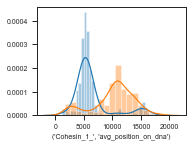

In [20]:
sns.distplot(df[('MCM_1_','avg_position_on_dna')])
sns.distplot(df[('Cohesin_1_','avg_position_on_dna')])

(-10.0, 100.0)

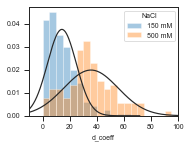

In [21]:
sns.distplot(df[df['nacl']=='150 mM']['Cohesin_1_']['d_coeff'], kde=False, fit=norm, bins=np.linspace(0,100,21), label='150 mM')
sns.distplot(df[df['nacl']=='500 mM']['Cohesin_1_']['d_coeff'], kde=False, fit=norm, bins=np.linspace(0,100,21), label='500 mM')
plt.legend(title='NaCl')
plt.xlim(-10,100)

In [23]:
df['nacl'].value_counts().sort_index()

150 mM    240
500 mM    106
Name: nacl, dtype: int64

In [24]:
df.groupby(['nacl','number_MCM']).describe()

molecule          ARS1 block                                            \
properties                                                               
                       count        mean         std  min   25%    50%   
nacl   number_MCM                                                        
150 mM 0.0              71.0   96.507042   49.944790  0.0  55.0  103.0   
       1.0             169.0  131.313609  208.395691  0.0  20.0   63.0   
500 mM 0.0              40.0   88.275000   45.544561  6.0  48.5   91.5   
       1.0              66.0  127.015152  164.955704  0.0  49.5   86.5   

molecule                          ARS1 block ni              ...  \
properties                                                   ...   
                      75%     max         count        mean  ...   
nacl   number_MCM                                            ...   
150 mM 0.0         130.00   198.0          71.0   96.507042  ...   
       1.0         131.00  1118.0         169.0   85.047337  ...   
500 mM 0.0         122.50   184.0          40.0   88.275000  ...   
       1.0         125.75  1042.0          66.0  111.863636  ...   

molecule          ARS1 passing probability            \
properties                                             
                                       75%       max   
nacl   number_MCM                                      
150 mM 0.0                        0.493562  0.677966   
       1.0                        0.142158  0.697674   
500 mM 0.0                        0.627232  0.781955   
       1.0                        0.417500  0.733945   

molecule          ARS1 passing probability ni                                \
properties                                                                    
                                        count      mean       std       min   
nacl   number_MCM                                                             
150 mM 0.0                               69.0  0.388203  0.134998  0.018868   
       1.0                              160.0  0.092770  0.130302  0.000000   
500 mM 0.0                               40.0  0.553791  0.140458  0.089109   
       1.0                               64.0  0.229009  0.217759  0.000000   

molecule                                                   
properties                                                 
                        25%       50%       75%       max  
nacl   number_MCM                                          
150 mM 0.0         0.297778  0.395122  0.493562  0.677966  
       1.0         0.000000  0.026334  0.156933  0.697674  
500 mM 0.0         0.528019  0.579339  0.627232  0.781955  
       1.0         0.009014  0.169980  0.417500  0.733945  

[4 rows x 256 columns]

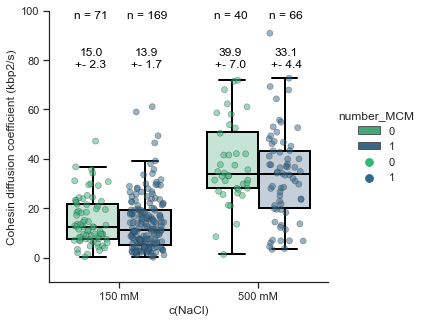

In [25]:
sns.set_context('notebook')
# Cohesin diffusion coefficient
fig,axes = plt.subplots(figsize=(5,5))


#setup style

#boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
kwargs = {'palette': 'viridis_r', 'hue_order': [0, 1]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.5},
                        **kwargs)



sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.25, **stripplot_kwargs)
#axes[1].artists
#axes.set_xlim(0,100)
axes.set_ylim(-10,100)
axes.set_xlabel('c(NaCl)')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')
axes.legend(bbox_to_anchor=[1, 0.5],frameon=False, title='number_MCM', loc='center left')


#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and ci
diffusion = []
# fit data to normal distribution and print on plot
for nacl in df['nacl'].sort_values().unique():
    for num_mcm in df['number_MCM'].sort_values().unique():
        mean = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].mean()
        sem = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].sem()*1.96
        diffusion.append(f'{round(mean,1)}\n+- {round(sem,1)}')

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 100, nobs[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 100, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick-.2, 85, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 85, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    ind += 2

for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
#axes[1].set_title('Different labels do not affect RNAP transcription')
sns.despine()

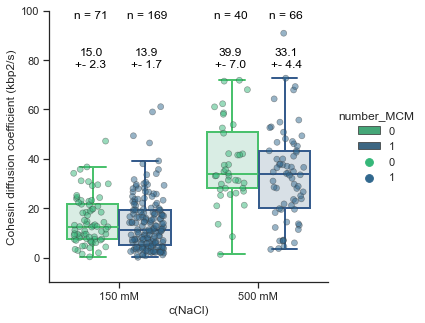

In [26]:
sns.set_context('notebook')
# Cohesin diffusion coefficient
fig,axes = plt.subplots(figsize=(5,5))


#setup style

#boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
kwargs = {'palette': 'viridis_r', 'hue_order': [0, 1]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.5},
                        **kwargs)



sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.25, **stripplot_kwargs)
#axes[1].artists
#axes.set_xlim(0,100)
axes.set_ylim(-10,100)
axes.set_xlabel('c(NaCl)')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')
axes.legend(bbox_to_anchor=[1, 0.5],frameon=False, title='number_MCM', loc='center left')


#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and ci
diffusion = []
# fit data to normal distribution and print on plot
for nacl in df['nacl'].sort_values().unique():
    for num_mcm in df['number_MCM'].sort_values().unique():
        mean = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].mean()
        sem = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].sem()*1.96
        diffusion.append(f'{round(mean,1)}\n+- {round(sem,1)}')

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 100, nobs[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 100, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick-.2, 85, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 85, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    ind += 2

for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    
#axes[1].set_title('Different labels do not affect RNAP transcription')
sns.despine()

for i, artist in enumerate(axes.artists):
    if i % 2 == 0:
        col = sns.color_palette('viridis_r')[1]
    else:
        col = sns.color_palette('viridis_r')[-2]

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = axes.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        

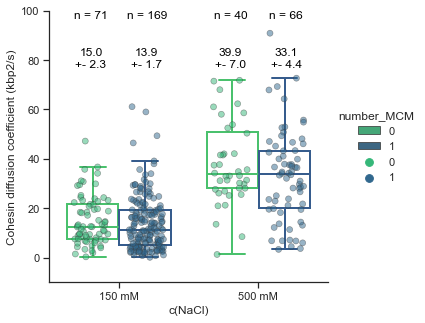

In [27]:
sns.set_context('notebook')
# Cohesin diffusion coefficient
fig,axes = plt.subplots(figsize=(5,5))


#setup style

boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
lineprops = {'color': 'k', 'linewidth': 2}
kwargs = {'palette': 'viridis_r', 'hue_order': [0, 1]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.5},
                        **kwargs)



sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='number_MCM',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.25, **stripplot_kwargs)
#axes[1].artists
#axes.set_xlim(0,100)
axes.set_ylim(-10,100)
axes.set_xlabel('c(NaCl)')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')
axes.legend(bbox_to_anchor=[1, 0.5],frameon=False, title='number_MCM', loc='center left')

#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and ci
diffusion = []
# fit data to normal distribution and print on plot
for nacl in df['nacl'].sort_values().unique():
    for num_mcm in df['number_MCM'].sort_values().unique():
        mean = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].mean()
        sem = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].sem()*1.96
        diffusion.append(f'{round(mean,1)}\n+- {round(sem,1)}')

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 100, nobs[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 100, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick-.2, 85, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 85, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    ind += 2

for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    
#axes[1].set_title('Different labels do not affect RNAP transcription')
sns.despine()

for i, artist in enumerate(axes.artists):
    if i % 2 == 0:
        col = sns.color_palette('viridis_r')[1]
    else:
        col = sns.color_palette('viridis_r')[-2]

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = axes.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

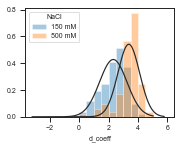

In [29]:
sns.distplot(np.log(df[df['nacl']=='150 mM']['Cohesin_1_']['d_coeff']), kde=False, fit=norm, bins=np.linspace(0,6,13), label='150 mM')
sns.distplot(np.log(df[df['nacl']=='500 mM']['Cohesin_1_']['d_coeff']), kde=False, fit=norm, bins=np.linspace(0,6,13), label='500 mM')
plt.legend(title='NaCl')

In [30]:
np.mean(df[df['nacl']=='150 mM']['Cohesin_1_']['d_coeff'])

14.190761866383545

In [31]:
np.mean(df[df['nacl']=='500 mM']['Cohesin_1_']['d_coeff'])

35.66341306264134

In [32]:
(df['Cohesin_1_']['d_coeff']).sem()*1.96

1.8271219618871637

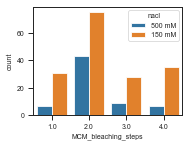

In [33]:
sns.countplot(x='MCM_bleaching_steps',hue='nacl',data=df)

In [34]:
# PAUSE REGIONS

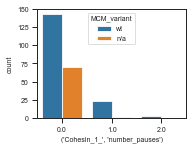

In [35]:
sns.countplot(x=('Cohesin_1_','number_pauses'), hue='MCM_variant',data=df[df['nacl']=='150 mM'])

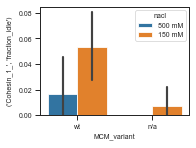

In [36]:
sns.barplot(x='MCM_variant', y=('Cohesin_1_','fraction_idle'), hue='nacl', data=df)

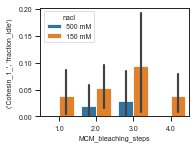

In [37]:
sns.barplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), hue='nacl', data=df)

In [38]:
df.columns

MultiIndex([(                 'ARS1 block',                       ''),
            (              'ARS1 block ni',                       ''),
            (                  'ARS1 pass',                       ''),
            (               'ARS1 pass ni',                       ''),
            (                 'Cohesin_1_',    'avg_position_on_dna'),
            (                 'Cohesin_1_', 'cum_pause_duration_(s)'),
            (                 'Cohesin_1_',                'd_coeff'),
            (                 'Cohesin_1_',                  'dtime'),
            (                 'Cohesin_1_',          'fraction_idle'),
            (                 'Cohesin_1_',      'initial_intensity'),
            (                 'Cohesin_1_',               'lifetime'),
            (                 'Cohesin_1_',                    'msd'),
            (                 'Cohesin_1_',          'number_pauses'),
            (                 'Cohesin_1_',           'timespan_(s)'),
      

## setup df_pause

In [40]:
df_pause = pd.DataFrame(columns=['MCM_at_origin', 'MCM_bleaching_steps', 'MCM_variant', 'nacl', 
                                 'pause_duration','MCM_position_on_dna', 'pause_position_on_dna', 'pause_at_MCM'])   
df_pause

,MCM_at_origin,MCM_bleaching_steps,MCM_variant,nacl,pause_duration,MCM_position_on_dna,pause_position_on_dna,pause_at_MCM


In [41]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # pauses:
        for region in molecule.regions:

            # check again for the right regions, prefixes and duration
            if ('idle' in region.name) and (region.prefix == 'Cohesin_1_') and (region.end - region.start >= 25):

                # temporary df
                _temp_df = pd.DataFrame()
                try:
                    _temp_df.loc[0,'MCM_at_origin'] = molecule.proteins['MCM'] > 0
                    _temp_df.loc[0,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
                    _temp_df.loc[0,'MCM_variant'] = archive.mcm
                    _temp_df.loc[0,'MCM_position_on_dna'] = molecule.df['MCM_1_Position_on_DNA'].median()
                except KeyError:
                    _temp_df.loc[0,'MCM_at_origin'] = False
                    _temp_df.loc[0,'MCM_variant'] = 'n/a'
                
                _temp_df.loc[0,'nacl'] = archive.nacl
                _temp_df.loc[0,'pause_duration'] = (molecule.df[molecule.df[region.prefix+region.column] == region.end][region.prefix+'Time_(s)'].item() - 
                                              molecule.df[molecule.df[region.prefix+region.column] == region.start][region.prefix+'Time_(s)'].item())
                
                _temp_df.loc[0,'pause_position_on_dna'] = molecule.df[(molecule.df[region.prefix+region.column] >= region.start) & 
                                                                (molecule.df[region.prefix+region.column] <= region.end)]['Cohesin_1_Position_on_DNA'].median()
 
                try:
                    _temp_df.loc[0,'pause_at_MCM'] = abs(_temp_df.loc[0,'MCM_position_on_dna'] - _temp_df.loc[0,'pause_position_on_dna']) <= 1500
                except KeyError:
                    pass
                         
            df_pause = pd.concat([df_pause, _temp_df])
            
# again sort MultiIndexCols for performance
df_pause.sort_index(axis=1, inplace=True)

# fix data types
df_pause = df_pause.infer_objects()

In [42]:
df_pause

,MCM_at_origin,MCM_bleaching_steps,MCM_position_on_dna,MCM_variant,nacl,pause_at_MCM,pause_duration,pause_position_on_dna
0,True,3.0,3536.266783,wt,500 mM,False,52.140,20173.783329
0,True,2.0,5107.475979,wt,500 mM,True,181.530,4840.273699
0,True,2.0,5273.016721,wt,150 mM,True,52.630,4932.590470
0,True,4.0,5049.834408,wt,150 mM,True,125.411,5164.722176
0,True,3.0,13035.814151,wt,150 mM,False,115.150,19359.930888
0,True,4.0,4958.434377,wt,150 mM,True,77.580,6106.968778
0,True,3.0,7077.017852,wt,150 mM,True,8.190,5596.728895
0,True,2.0,5324.481452,wt,150 mM,True,5.260,4700.725920
0,True,1.0,5529.985371,wt,150 mM,False,37.480,18250.571016
0,True,4.0,4791.776182,wt,150 mM,True,5.180,4098.946904


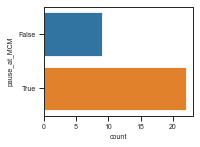

In [43]:
sns.countplot(y='pause_at_MCM', data=df_pause)

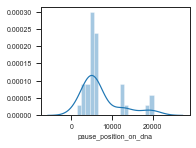

In [44]:
sns.distplot(df_pause['pause_position_on_dna'])

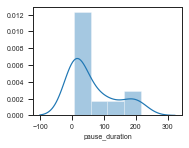

In [45]:
sns.distplot(df_pause['pause_duration'])

In [46]:
df2.head()

molecule               ARS1 block ARS1 block ni ARS1 pass ARS1 pass ni  \
properties                                                               
2PFd8LrNDti9JB4QSh3mR9       56.0          56.0      30.0         30.0   
2QGskSzFLzrBr7YLN78knZ      100.0         100.0     148.0        148.0   
2Z4r51hJSvdkiVDjjqKUrj      112.0         112.0      56.0         56.0   
2sTgZedaFFf9CK5b3GF6Cn       13.0          13.0      24.0         24.0   
3AoBkpRczab2PADB4kryfY      153.0         153.0       4.0          4.0   

molecule                        Cohesin_1_                                    \
properties             avg_position_on_dna cum_pause_duration_(s)    d_coeff   
2PFd8LrNDti9JB4QSh3mR9        10644.210476                    0.0  19.546419   
2QGskSzFLzrBr7YLN78knZ        11142.190365                    0.0  29.767491   
2Z4r51hJSvdkiVDjjqKUrj         7348.886267                    0.0  43.310971   
2sTgZedaFFf9CK5b3GF6Cn        12755.246844                    0.0  52.460617   
3AoBkpRczab2PADB4kryfY        12054.104532                    0.0  23.531469   

molecule                                                          ...  \
properties                 dtime fraction_idle initial_intensity  ...   
2PFd8LrNDti9JB4QSh3mR9  0.187930           0.0           86644.6  ...   
2QGskSzFLzrBr7YLN78knZ  0.182752           0.0           29989.5  ...   
2Z4r51hJSvdkiVDjjqKUrj  0.183297           0.0           19703.6  ...   
2sTgZedaFFf9CK5b3GF6Cn  0.184878           0.0            9802.7  ...   
3AoBkpRczab2PADB4kryfY  0.184084           0.0           33791.1  ...   

molecule               dna_length label_Cohesin   label_MCM    nacl  \
properties                                                            
2PFd8LrNDti9JB4QSh3mR9  38.988975    Halo-JF549  ybbR-LD655  500 mM   
2QGskSzFLzrBr7YLN78knZ  43.426647    Halo-JF549  ybbR-LD655  500 mM   
2Z4r51hJSvdkiVDjjqKUrj  36.079005    Halo-JF549  ybbR-LD655  500 mM   
2sTgZedaFFf9CK5b3GF6Cn  31.864820    Halo-JF549  ybbR-LD655  500 mM   
3AoBkpRczab2PADB4kryfY  42.316194    Halo-JF549  ybbR-LD655  500 mM   

molecule               nucleotide number_Cohesin number_MCM  \
properties                                                    
2PFd8LrNDti9JB4QSh3mR9        ATP            1.0        1.0   
2QGskSzFLzrBr7YLN78knZ        ATP            1.0        0.0   
2Z4r51hJSvdkiVDjjqKUrj        ATP            1.0        1.0   
2sTgZedaFFf9CK5b3GF6Cn        ATP            1.0        0.0   
3AoBkpRczab2PADB4kryfY        ATP            1.0        1.0   

molecule                             tags ARS1 passing probability  \
properties                                                           
2PFd8LrNDti9JB4QSh3mR9           [accept]                 0.348837   
2QGskSzFLzrBr7YLN78knZ           [accept]                 0.596774   
2Z4r51hJSvdkiVDjjqKUrj           [accept]                 0.333333   
2sTgZedaFFf9CK5b3GF6Cn           [accept]                 0.648649   
3AoBkpRczab2PADB4kryfY  [accept, perfect]                 0.025478   

molecule               ARS1 passing probability ni  
properties                                          
2PFd8LrNDti9JB4QSh3mR9                    0.348837  
2QGskSzFLzrBr7YLN78knZ                    0.596774  
2Z4r51hJSvdkiVDjjqKUrj                    0.333333  
2sTgZedaFFf9CK5b3GF6Cn                    0.648649  
3AoBkpRczab2PADB4kryfY                    0.025478  

[5 rows x 39 columns]

In [47]:
df2['ARS1 passing probability'] = df2['ARS1 pass'] / df2['Visualized encounters']
df2

/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


molecule               ARS1 block ARS1 block ni ARS1 pass ARS1 pass ni  \
properties                                                               
2PFd8LrNDti9JB4QSh3mR9       56.0          56.0      30.0         30.0   
2QGskSzFLzrBr7YLN78knZ      100.0         100.0     148.0        148.0   
2Z4r51hJSvdkiVDjjqKUrj      112.0         112.0      56.0         56.0   
2sTgZedaFFf9CK5b3GF6Cn       13.0          13.0      24.0         24.0   
3AoBkpRczab2PADB4kryfY      153.0         153.0       4.0          4.0   
...                           ...           ...       ...          ...   
uD2qeX3fcDrkHLrEykKP3x       94.0          94.0      87.0         87.0   
uwCQQd5mMKFh5gQwnP9b3p      120.0         120.0     110.0        110.0   
vbQbfgRcaVUyxLdweJ2Y7p       39.0          39.0      25.0         25.0   
xcfK4nJ1oobZtYbMGVJHYQ       93.0          93.0      16.0         16.0   
xtREv4R9FAjgZ88vrbJPJM       65.0          65.0      61.0         61.0   

molecule                        Cohesin_1_                                    \
properties             avg_position_on_dna cum_pause_duration_(s)    d_coeff   
2PFd8LrNDti9JB4QSh3mR9        10644.210476                    0.0  19.546419   
2QGskSzFLzrBr7YLN78knZ        11142.190365                    0.0  29.767491   
2Z4r51hJSvdkiVDjjqKUrj         7348.886267                    0.0  43.310971   
2sTgZedaFFf9CK5b3GF6Cn        12755.246844                    0.0  52.460617   
3AoBkpRczab2PADB4kryfY        12054.104532                    0.0  23.531469   
...                                    ...                    ...        ...   
uD2qeX3fcDrkHLrEykKP3x        11509.738841                    0.0  19.707632   
uwCQQd5mMKFh5gQwnP9b3p        10813.865049                    0.0  22.283112   
vbQbfgRcaVUyxLdweJ2Y7p        10364.155308                    0.0  11.486890   
xcfK4nJ1oobZtYbMGVJHYQ        12603.288771                    0.0   3.351588   
xtREv4R9FAjgZ88vrbJPJM        10339.047184                    0.0  18.089110   

molecule                                                          ...  \
properties                 dtime fraction_idle initial_intensity  ...   
2PFd8LrNDti9JB4QSh3mR9  0.187930           0.0           86644.6  ...   
2QGskSzFLzrBr7YLN78knZ  0.182752           0.0           29989.5  ...   
2Z4r51hJSvdkiVDjjqKUrj  0.183297           0.0           19703.6  ...   
2sTgZedaFFf9CK5b3GF6Cn  0.184878           0.0            9802.7  ...   
3AoBkpRczab2PADB4kryfY  0.184084           0.0           33791.1  ...   
...                          ...           ...               ...  ...   
uD2qeX3fcDrkHLrEykKP3x  0.185782           0.0           24928.3  ...   
uwCQQd5mMKFh5gQwnP9b3p  0.186097           0.0           42789.6  ...   
vbQbfgRcaVUyxLdweJ2Y7p  0.185274           0.0           11532.8  ...   
xcfK4nJ1oobZtYbMGVJHYQ  0.185053           0.0           12821.3  ...   
xtREv4R9FAjgZ88vrbJPJM  0.186255           0.0           23820.3  ...   

molecule               dna_length label_Cohesin   label_MCM    nacl  \
properties                                                            
2PFd8LrNDti9JB4QSh3mR9  38.988975    Halo-JF549  ybbR-LD655  500 mM   
2QGskSzFLzrBr7YLN78knZ  43.426647    Halo-JF549  ybbR-LD655  500 mM   
2Z4r51hJSvdkiVDjjqKUrj  36.079005    Halo-JF549  ybbR-LD655  500 mM   
2sTgZedaFFf9CK5b3GF6Cn  31.864820    Halo-JF549  ybbR-LD655  500 mM   
3AoBkpRczab2PADB4kryfY  42.316194    Halo-JF549  ybbR-LD655  500 mM   
...                           ...           ...         ...     ...   
uD2qeX3fcDrkHLrEykKP3x  37.013511    Halo-JF549         NaN  150 mM   
uwCQQd5mMKFh5gQwnP9b3p  35.057096    Halo-JF549         NaN  150 mM   
vbQbfgRcaVUyxLdweJ2Y7p  36.667045    Halo-JF549         NaN  150 mM   
xcfK4nJ1oobZtYbMGVJHYQ  31.016125    Halo-JF549         NaN  150 mM   
xtREv4R9FAjgZ88vrbJPJM  36.013886    Halo-JF549         NaN  150 mM   

molecule               nucleotide number_Cohesin number_MCM  \
properties                                                 

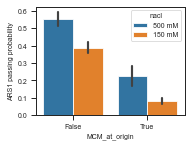

In [49]:
sns.barplot(x='MCM_at_origin', y='ARS1 passing probability',hue='nacl', data=df2)

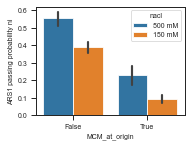

In [50]:
sns.barplot(x='MCM_at_origin', y='ARS1 passing probability ni',hue='nacl', data=df2)

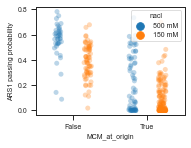

In [51]:
sns.stripplot(x='MCM_at_origin', y='ARS1 passing probability',hue='nacl', data=df2,dodge=True, alpha=0.3)

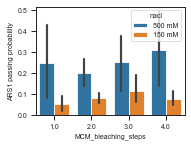

In [52]:
sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability',hue='nacl', data=df2)

## Figures

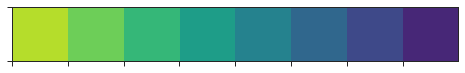

In [70]:
sns.palplot(palette)

### 1 - Cohesin diffusion coefficient (pause segments excluded)

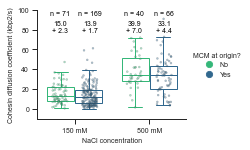

In [168]:
fig,axes = plt.subplots()

#setup style

boxprops = {'edgecolor': 'k', 'linewidth': 1, 'facecolor':'w'}
lineprops = {'color': 'k', 'linewidth': 1}
kwargs = {'hue_order': [False, True]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.4},
                        **kwargs)

sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='MCM_at_origin',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, palette=palette[2::3], **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='MCM_at_origin',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.2, palette=palette[2::3], **stripplot_kwargs)

axes.set_ylim(-10,100)
axes.set_xlabel('NaCl concentration')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')

#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and ci
diffusion = []
# fit data to normal distribution and print on plot
for nacl in df['nacl'].sort_values().unique():
    for num_mcm in df['number_MCM'].sort_values().unique():
        mean = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].mean()
        sem = df[(df['nacl']==nacl) & (df['number_MCM']==num_mcm)][('Cohesin_1_','d_coeff')].sem()*1.96
        diffusion.append(f'{round(mean,1)}\n+ {round(sem,1)}')

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 100, nobs[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 100, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick-.2, 90, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='k')
    axes.text(tick+.2, 90, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='k')
    ind += 2

# alpha for boxplot filling (not required here)
for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    
for i, artist in enumerate(axes.artists):
    if i % 2 == 0:
        col = palette[2]
    else:
        col = palette[5]

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = axes.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        
# Fix the legend, keep only the first two legend elements
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles[2:], ['No', 'Yes'], frameon=False, title='MCM at origin?',
               loc='center left', bbox_to_anchor=[1, 0.5],handletextpad=0.5)

lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]

sns.despine()

plt.savefig(dir_out+'Cohesin_diffusion_coefficient.svg',transparent=True)

### 2 - MCM barrier for cohesin translocation

### a - 150 mM NaCl - including pause segments

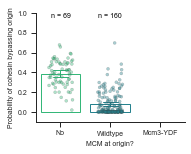

In [256]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'k'}

kwargs = {'order': ['n/a', 'wt', 'YDF']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes, capsize=.3,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='k')

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_incl-pause.svg',transparent=True)

### b - 150 mM NaCl - excluding pause segments

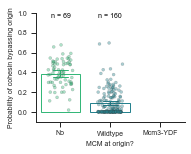

In [257]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'k'}

kwargs = {'order': ['n/a', 'wt', 'YDF']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes, capsize=.3,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='k')

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_excl-pause.svg',transparent=True)

### c - 500 mM NaCl - including pause segments (initial submission)

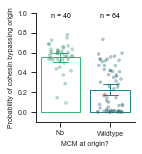

In [258]:
fig,axes = plt.subplots(figsize=(1.78,2))
nacl_conc = '500 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'k'}

kwargs = {'order': ['n/a', 'wt']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes, capsize=.3,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='k')

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_500mM_incl-pause.svg',transparent=True)


### d - 500 mM NaCl - excluding pause segments

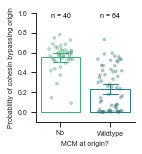

In [259]:
fig,axes = plt.subplots(figsize=(1.78,2))
nacl_conc = '500 mM'
data = df2[df2['nacl'] == nacl_conc]
           
barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'k'}

kwargs = {'order': ['n/a', 'wt']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes, capsize=.3,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='k')

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_500mM_excl-pause.svg',transparent=True)

### 3 - MCM barrier for cohesin translocation vs #MCM(wt) (excl. pause segments)

### a - 150 mM NaCl

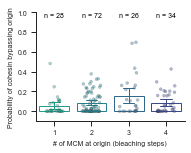

In [260]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'k'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes, capsize=.3,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='k')
    
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-wt_150mM.svg',transparent=True)

### b - 500 mM NaCl

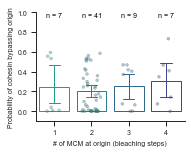

In [262]:
fig,axes = plt.subplots()
nacl_conc = '500 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'k'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes, capsize=.3,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='k')
    
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-wt_500mM.svg',transparent=True)

In [263]:
# can add a hue for MCM_variant (data with number_MCM > 0 only) later for comparison

### 4 - Pauses in cohesin translocation (150 mM data only)